In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
! pip install contractions
! pip install wordcloud
! pip install scikit-learn-intelex
! pip install symspellpy
! pip install lazypredict

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import random
import re
import contractions
import time
from collections import defaultdict
import seaborn as sns

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from wordcloud import WordCloud,STOPWORDS
from symspellpy import SymSpell, Verbosity
from lazypredict.Supervised import LazyClassifier

import pickle

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

start_time = time.time()


train_df = pd.read_csv('/kaggle/input/whysoharsh/train.csv')
test_df = pd.read_csv('/kaggle/input/whysoharsh/test.csv')
sample_df = pd.read_csv('/kaggle/input/whysoharsh/sample.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 kB 3.7 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
train_df.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [4]:
train_df.isna().sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

In [5]:
train_df.nunique()

id                 89359
text               89359
harsh                  2
extremely_harsh        2
vulgar                 2
threatening            2
disrespect             2
targeted_hate          2
dtype: int64

In [6]:
len(train_df)

89359

In [7]:
print(train_df['text'][62088])

"Hello, and welcome to Wikipedia.  

Helpful links  Editing || Writing a great article || Naming and Merging || Style Manual || Policies  Reassigning old edits || What Wikipedia is not

Maintenance  Deleting articles ||  all maintenance tasks (see also open tasks, below)

Uploading images: please note the origins and copyright status of every image you upload.

 To sign your comments, type four tildes like this:  ~~~~. 
 This automatically adds your name and the current time.

I hope you enjoy being a Wikipedian on en:.  Drop us a note at Wikipedia:New user log so we can meet you and help you get started.  
You can also leave questions on my talk page. :)

Regards, + 

"


## EDA

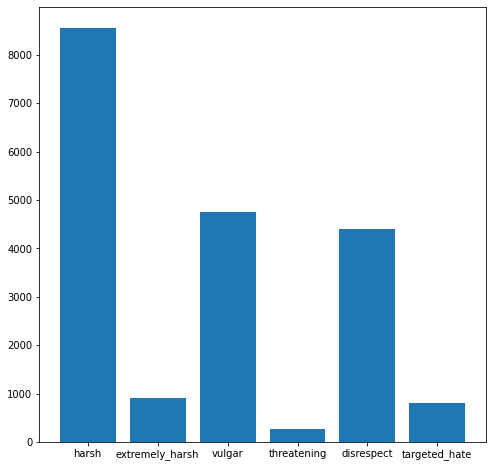

{'harsh': 8559, 'extremely_harsh': 917, 'vulgar': 4742, 'threatening': 268, 'disrespect': 4392, 'targeted_hate': 802}


In [8]:
map = {
    'harsh' : train_df['harsh'].sum(),
    'extremely_harsh': train_df['extremely_harsh'].sum(),
    'vulgar': train_df['vulgar'].sum(),
    'threatening': train_df['threatening'].sum(),
    'disrespect': train_df['disrespect'].sum(),
    'targeted_hate': train_df['targeted_hate'].sum()
}

names = list(map.keys())
values = list(map.values())

plt.rcParams["figure.figsize"] = (8,8)

plt.bar(range(len(map)),values, tick_label=names)
plt.show()
print(map)

<AxesSubplot:>

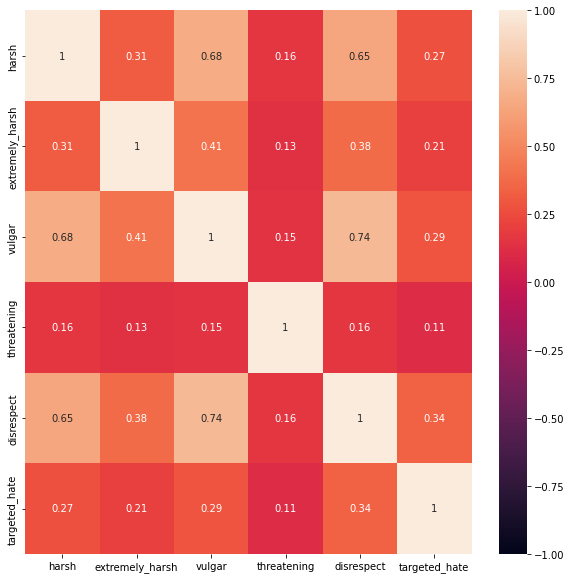

In [9]:
train_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(train_df.corr(), vmin=-1,annot=True)

## Fixing Contractions

In [10]:
train_df['text'] = train_df['text'].apply(lambda s: contractions.fix(s))
test_df['text'] = test_df['text'].apply(lambda s: contractions.fix(s))

## Converting to lowercase letters

In [11]:
train_df['text'] = train_df['text'].apply(lambda s: s.lower())
test_df['text'] = test_df['text'].apply(lambda s: s.lower())

## Replacing emoticons

In [12]:
emoticons = {
    ':-)': 'happy',
    ':)': 'happy',
    ':-(': 'frown',
    ':(': 'frown',
    'xD': 'laugh',
    ':/': 'sad',
    ':|': 'indecision',
    ':o': 'surprise',
    '<3': 'heart'
}

In [13]:
emojis = list(emoticons.keys())
meanings = list(emoticons.values())

def replace_emoji(text):
  sentence = ''
  for word in str(text).split():
    if word in emoticons:
      word = emoticons[word]
    sentence += word + ' '
  return sentence

train_df['text'] = train_df['text'].apply(lambda s: replace_emoji(s))
test_df['text'] = test_df['text'].apply(lambda s: replace_emoji(s))

In [14]:
print(train_df['text'][62088])

"hello, and welcome to wikipedia. helpful links editing || writing a great article || naming and merging || style manual || policies reassigning old edits || what wikipedia is not maintenance deleting articles || all maintenance tasks (see also open tasks, below) uploading images: please note the origins and copyright status of every image you upload. to sign your comments, type four tildes like this: ~~~~. this automatically adds your name and the current time. i hope you enjoy being a wikipedian on en:. drop us a note at wikipedia:new user log so we can meet you and help you get started. you can also leave questions on my talk page. happy regards, + " 


## Removing punctuation marks


In [15]:
train_df['text'] = train_df['text'].apply(lambda s: re.sub(r'[^\w\s]', '', s))
test_df['text'] = test_df['text'].apply(lambda s: re.sub(r'[^\w\s]', '', s))

## Removing all numbers

In [16]:
train_df['text'] = train_df['text'].apply(lambda s: re.sub(r'\d+', '', s))
test_df['text'] = test_df['text'].apply(lambda s: re.sub(r'\d+', '', s))

## Correcting spellings of words

In [17]:
sym_spell = SymSpell()
corpus_path = '/kaggle/input/whysoharsh/frequency_dictionary_en_82_765.txt'
sym_spell.create_dictionary(corpus_path)

True

In [18]:
# def correct_spelling(text):
#     s = ''
#     for w in str(text).split():
#         suggestions = sym_spell.lookup(w, Verbosity.CLOSEST,
#                                max_edit_distance=2, include_unknown=True)
#         s += suggestions[0].term
#     return s

def correct_spelling(text):
    return ' '.join([sym_spell.lookup(w, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term for w in str(text).split()])

train_df['text'] = train_df['text'].apply(lambda s: correct_spelling(s))
test_df['text'] = test_df['text'].apply(lambda s: correct_spelling(s))

## Removing words containing digits (Eg: hello123) 

In [19]:
train_df['text'] = train_df['text'].apply(lambda s: re.sub(r'\w*\d\w*', '', s))
test_df['text'] = test_df['text'].apply(lambda s: re.sub(r'\w*\d\w*', '', s))

## Removing stop words

In [20]:
# stop_words = set(stopwords.words('english'))
# stop_words.update(['http', 'https', 'www', 'html', 'jpg', 'htm']) # Add some more words

# def stop(text):
#     return ' '.join([w for w in str(text).split() if w not in stop_words])

# train_df['text'] = train_df['text'].apply(lambda s: stop(s))
# test_df['text'] = test_df['text'].apply(lambda s: stop(s))

## Lemmatization

In [21]:
# lemmatizer = WordNetLemmatizer()

# def lemma(text):
#      return ' '.join([lemmatizer.lemmatize(w) for w in str(text).split()])
    
# train_df['text'] = train_df['text'].apply(lambda s: lemma(s))
# test_df['text'] = test_df['text'].apply(lambda s: lemma(s))

## Stemming

In [22]:
stemmer = SnowballStemmer('english')

def stemm(text):
     return ' '.join([stemmer.stem(w) for w in str(text).split()])
    
train_df['text'] = train_df['text'].apply(lambda s: stemm(s))
test_df['text'] = test_df['text'].apply(lambda s: stemm(s))

## Vectorization

In [23]:
tfidfVectorizer = TfidfVectorizer(
    strip_accents = 'unicode', # Remove accents and perform other character normalization during the preprocessing step
    analyzer = 'word',
    stop_words = 'english',
    ngram_range = (1, 2) ,
    max_df = 0.5, # ignore terms that appear in more than 50% of the documents
    min_df = 2, # ignore terms that appear in less than 2 documents
    sublinear_tf = True # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)

char_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    analyzer = 'char',
    min_df = 2,
    max_df = 0.5,
    ngram_range = (2, 6),
    sublinear_tf = True
)

train_text_list = train_df['text']
test_text_list = test_df['text']

whole_text = pd.concat([train_text_list, test_text_list])

tfidfVectorizer.fit(whole_text)
X_train_vectorized = tfidfVectorizer.transform(train_text_list)
X_test_vectorized = tfidfVectorizer.transform(test_text_list)

char_vectorizer.fit(whole_text)
train_char_features = char_vectorizer.transform(train_text_list)
test_char_features = char_vectorizer.transform(test_text_list)

from scipy.sparse import hstack

X_train_vectorized = hstack([X_train_vectorized, train_char_features]).tocsr()
X_test_vectorized = hstack([X_test_vectorized, test_char_features]).tocsr()

pickle.dump(X_train_vectorized, open('XTrainVecMaxFeatures.pkl', 'wb'))
pickle.dump(X_test_vectorized, open('XTestVecMaxFeatures.pkl', 'wb'))

## Extracting vectorized data from pickle files

### Lemmatized data

In [24]:
# train_file_path = '/kaggle/input/whysoharsh/XTrainVecMaxFeaturesupdated.pkl'
# test_file_path = '/kaggle/input/whysoharsh/XTestVecMaxFeaturesupdated.pkl'

# with open(train_file_path , 'rb') as trainf:
#     X_train_vectorized = pickle.load(trainf)

# with open(test_file_path , 'rb') as testf:
#     X_test_vectorized = pickle.load(testf)

### Stemmed data

In [25]:
train_file_path = '/kaggle/input/whysoharsh/XTrainVecMaxFeatures_Stemmer.pkl'
test_file_path = '/kaggle/input/whysoharsh/XTestVecMaxFeatures_Stemmer.pkl'

with open(train_file_path , 'rb') as trainf:
    X_train_vectorized = pickle.load(trainf)

with open(test_file_path , 'rb') as testf:
    X_test_vectorized = pickle.load(testf)

## Logistic Regression

In [26]:
categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

predictions = {
    'id': test_df['id']
}

roc_score =[]

for c in categories:
    Y = train_df[c].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
    lr = LogisticRegression(class_weight='balanced', C=1, solver='lbfgs')
    lr.fit(x_train, y_train)

    predictions[c] = lr.predict_proba(X_test_vectorized)[:, 1]

    roc_score.append(roc_auc_score(y_test, lr.predict_proba(x_test)[:, 1]))

df_submit = pd.DataFrame(predictions)

df_submit.to_csv('submission_lr.csv', index=None)

print(np.mean(roc_score))
pickle.dump(lr, open('model_lr.pkl', 'wb'))

0.9843876380885671


## Classifier chain

In [27]:
categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

predictions = {
    'id': test_df['id']
}

roc_score =[]

for c in categories:
    Y = train_df[c].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
    base_lr = LogisticRegression(class_weight='balanced', C=1, random_state=0)
    chain = ClassifierChain(base_lr, order='random', random_state=0)
    chain.fit(x_train, y_train.reshape(-1,1))
    predictions[c] = chain.predict_proba(X_test_vectorized)[:,0]

    roc_score.append(roc_auc_score(y_test, chain.predict_proba(x_test)))

df_submit = pd.DataFrame(predictions)

df_submit.to_csv('submission_cc.csv', index=None)

print(np.mean(roc_score))
pickle.dump(chain, open('model_cc.pkl', 'wb'))

0.9843876380885671


## SGDClassifier

In [28]:
categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

predictions = {
    'id': test_df['id']
}

roc_score =[]

for c in categories:
    Y = train_df[c].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
    sgdc = SGDClassifier(loss="log", penalty="l2", max_iter=100000, class_weight='balanced')
    sgdc.fit(x_train, y_train)

    predictions[c] = sgdc.predict_proba(X_test_vectorized)[:, 1]

    roc_score.append(roc_auc_score(y_test, sgdc.predict_proba(x_test)[:, 1]))

df_submit = pd.DataFrame(predictions)

df_submit.to_csv('submission_sgdc.csv', index=None)

print(np.mean(roc_score))
pickle.dump(sgdc, open('model_sgdc.pkl', 'wb'))

0.9824327470814311


## Ridge

In [29]:
from sklearn.linear_model import Ridge

categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

predictions = {
    'id': test_df['id']
}

roc_score =[]

for c in categories:
    Y = train_df[c].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
    rid = Ridge(copy_X=True, solver='sag', random_state=33, alpha=45)
    rid.fit(x_train, y_train)
    
    pred_y = rid.predict(x_test)
    roc_score.append(roc_auc_score(y_test, pred_y))
    
    rid.fit(X_train_vectorized, Y)
    predictions[c] = rid.predict(X_test_vectorized)

df_submit = pd.DataFrame(predictions)

df_submit.to_csv('submission_rid.csv', index=None)

print(roc_score)
print(np.mean(roc_score))
pickle.dump(rid, open('model_rid.pkl', 'wb'))

[0.9736407906269599, 0.9876346093886516, 0.9912239771745617, 0.9887910150404071, 0.9808938879896368, 0.9783844088234132]
0.983428114840605


In [30]:
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(X_test)

## Random Forest Classifier

In [31]:
# from sklearn.ensemble import RandomForestClassifier
# categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

# predictions = {
#     'id': test_df['id']
# }

# roc_score =[]

# for c in categories:
#     Y = train_df[c].to_numpy()
#     x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
#     p = RandomForestClassifier(criterion='gini',
#             max_depth=100, max_features=500, max_leaf_nodes=None, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=120)
#     clf = p.fit(x_train, y_train)
#     calibrator = CalibratedClassifierCV(clf, cv='prefit')
#     model = calibrator.fit(x_train, y_train)
#     sgdc.fit(x_train, y_train)

#     predictions[c] = model.predict_proba(X_test_vectorized)[:, 1]

#     roc_score.append(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

# df_submit = pd.DataFrame(predictions)

# df_submit.to_csv('submission_rfc.csv', index=None)

# print(np.mean(roc_score))
# pickle.dump(sgdc, open('model_rfc.pkl', 'wb'))

## Hyperparameter Tuning

In [32]:
# param = {
#         'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#         'penalty':['l2', None],
# #         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#         'solver': ['lbfgs', 'sag'],
#         'class_weight': ['balanced', None]
# }

# Y = train_df['targeted_hate'].to_numpy()
# x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42)
# lr = LogisticRegression()

# rscv = RandomizedSearchCV(lr, param, cv = 5, scoring='roc_auc')
 
# rscv.fit(x_train, y_train)

# print("Tuned Logistic Regression: {}".format(rscv.best_params_))
# print("Best score is {}".format(rscv.best_score_))

In [33]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2723.5653455257416 seconds ---


## LazyClassifier

In [34]:
# from sklearn.dummy import DummyClassifier
# from sklearn.svm import LinearSVC, SVC
# from sklearn.linear_model import SGDClassifier, Perceptron, RidgeClassifierCV, RidgeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.calibration import CalibratedClassifierCV

# lst = [
#     SGDClassifier,
#     MLPClassifier,
#     Perceptron,
#     RidgeClassifierCV,
#     RidgeClassifier,
#     AdaBoostClassifier,
#     DecisionTreeClassifier,
#     RandomForestClassifier,
#     GradientBoostingClassifier,
#     CalibratedClassifierCV
# ]



# Y = train_df['harsh'].to_numpy()
# x_train, x_test, y_train, y_test = train_test_split(
#     X_train_vectorized.toarray(), Y, test_size=0.3, random_state=42, stratify=Y)
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(x_train, x_test, y_train, y_test)
# models

In [35]:
# harsh
# Tuned Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None, 'C': 1.0}
# Best score is 0.8822488135549081

# extremely_harsh
# Tuned Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
# Best score is 0.9518445766028873

# vulgar
# Tuned Logistic Regression: {'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
# Best score is 0.919135750971037

# threatening
# Tuned Logistic Regression: {'solver': 'sag', 'penalty': 'l2', 'class_weight': None, 'C': 0.01}
# Best score is 0.9130528254342402

# disrespect
# Tuned Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 10.0}
# Best score is 0.9013409662854655

# targeted_hate
# Tuned Logistic Regression: {'solver': 'saga', 'penalty': 'l2', 'class_weight': None, 'C': 0.1}
# Best score is 0.9344772282735206

## Some other models: Support Vector Classification


In [36]:
# from sklearn.svm import SVC
# categories = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']


# predictions = {
#     'id': test_df['id']
# }

# roc_score =[]

# for c in categories:
#     Y = train_df[c].to_numpy()
#     x_train, x_test, y_train, y_test = train_test_split(X_train_vectorized, Y, test_size=0.3, random_state=42, stratify=Y)
#     svc = SVC()
#     svc.fit(x_train, y_train)
#     predictions[c] = svc.predict(X_test_vectorized)[0]

#     roc_score.append(roc_auc_score(y_test, lr.predict_proba(x_test)[:, 1]))

# df_submit = pd.DataFrame(predictions)

# df_submit.to_csv('submission_svm_svc.csv', index=None)

# print(np.mean(roc_score))
# pickle.dump(chain, open('model_svm_svc.pkl', 'wb'))

## References

1. https://stackoverflow.com/a/30315056/15069364
2. https://www.geeksforgeeks.org/python-remove-punctuation-from-string/ 
3. https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
4. https://stackoverflow.com/a/18082240/15069364
5. https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d
6. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
7. https://stackoverflow.com/a/35615151/15069364
8. https://en.wikipedia.org/wiki/List_of_emoticons
9. https://stackoverflow.com/a/1557584/15069364
10. https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
11. https://datascience.stackexchange.com/questions/40584/meaning-of-stratify-parameter